# Analyzing Audits

**Predicting Cell Health**

**Gregory Way, 2020**

Detecting replicate correlation across replicates and CRISPR guides targeting the same gene.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotnine as gg

from pycytominer import audit

from scripts.audit_utils import get_confidence

In [2]:
np.random.seed(123)

In [3]:
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
profile_file = os.path.join(
    "..", "1.generate-profiles", "data", "processed", "cell_health_profiles_merged.tsv.gz"
)

profile_df = pd.read_csv(profile_file, sep='\t')

print(profile_df.shape)
profile_df.head()

(3456, 956)


,Metadata_Plate,Metadata_Well,Metadata_WellCol,Metadata_WellRow,Metadata_cell_line,Metadata_gene_name,Metadata_pert_name,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_AGP_20_0,Nuclei_Texture_SumVariance_AGP_5_0,Nuclei_Texture_SumVariance_DNA_10_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_AGP_5_0,Nuclei_Texture_Variance_DNA_10_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,SQ00014618,A01,1,A,HCC44,EMPTY,EMPTY,-0.894997,-1.515696,-1.787667,...,0.107581,-0.659049,-0.676846,-1.229791,-1.336051,-1.125138,-0.972360,-1.393856,-1.244227,-1.308729
1,SQ00014618,A02,2,A,HCC44,MCL1,MCL1-5,-0.479926,0.246423,0.629901,...,0.165935,1.999006,1.204036,0.560228,0.686189,0.601634,1.154001,0.596441,0.680359,0.715469
2,SQ00014618,A03,3,A,HCC44,AKT1,AKT1-1,-0.635578,0.416772,0.039795,...,-1.358338,0.155556,-0.112177,-1.258864,-1.394609,-1.277509,-0.128419,-1.359460,-1.299859,-1.396879
3,SQ00014618,A04,4,A,HCC44,KRAS,KRAS-2B,1.024707,0.645336,0.714847,...,-0.975661,-0.931362,-0.809894,-1.526434,-1.541661,-1.482596,-1.004789,-1.817028,-1.887102,-1.681831
4,SQ00014618,A05,5,A,HCC44,AKT1,AKT1-2,-2.036443,0.159822,0.736176,...,-0.575835,0.093271,-0.298606,-0.564712,-0.512144,-0.513650,-0.438356,-0.562306,-0.276279,-0.547497


In [5]:
# How many replicates per perturbation?
(
    profile_df
    .groupby(["Metadata_cell_line","Metadata_gene_name", "Metadata_pert_name"])
    ["Metadata_Plate"]
    .count()
    .value_counts()
)

6      300
24      42
12       6
168      3
15       3
9        3
Name: Metadata_Plate, dtype: int64

## Perform Audit of Genes and Guides 

In [6]:
audit_gene_groups = ["Metadata_cell_line", "Metadata_gene_name"]
audit_guide_groups = ["Metadata_cell_line", "Metadata_gene_name", "Metadata_pert_name"]

# Perform a full audit and collect cell line, gene, and guide metadata
audit_gene_df = audit(
    profile_df,
    audit_groups=audit_guide_groups,
    audit_resolution="full"
)

print(audit_gene_df.shape)
audit_gene_df.head()

(5970240, 10)


,column_match_pair_a,Metadata_cell_line_pair_a,Metadata_gene_name_pair_a,Metadata_pert_name_pair_a,row_match,pairwise_correlation,column_match_pair_b,Metadata_cell_line_pair_b,Metadata_gene_name_pair_b,Metadata_pert_name_pair_b
1,1,HCC44,MCL1,MCL1-5,0,0.276545,0,HCC44,EMPTY,EMPTY
2,2,HCC44,AKT1,AKT1-1,0,0.634494,0,HCC44,EMPTY,EMPTY
3,3,HCC44,KRAS,KRAS-2B,0,0.510447,0,HCC44,EMPTY,EMPTY
4,4,HCC44,AKT1,AKT1-2,0,0.432352,0,HCC44,EMPTY,EMPTY
5,5,HCC44,EMPTY,EMPTY,0,0.635684,0,HCC44,EMPTY,EMPTY


In [7]:
# Determine gene replicates
pair_a_df = audit_gene_df.loc[:, ["{}_pair_a".format(x) for x in audit_gene_groups]]
pair_a_df.columns = audit_gene_groups
pair_b_df = audit_gene_df.loc[:, ["{}_pair_b".format(x) for x in audit_gene_groups]]
pair_b_df.columns = audit_gene_groups

audit_gene_df = audit_gene_df.assign(
    replicate_gene_info=(pair_a_df == pair_b_df).all(axis="columns")
)

# Determine guide replicates
pair_a_df = audit_gene_df.loc[:, ["{}_pair_a".format(x) for x in audit_guide_groups]]
pair_a_df.columns = audit_guide_groups
pair_b_df = audit_gene_df.loc[:, ["{}_pair_b".format(x) for x in audit_guide_groups]]
pair_b_df.columns = audit_guide_groups

audit_gene_df = audit_gene_df.assign(
    replicate_guide_info=(pair_a_df == pair_b_df).all(axis="columns")
)

print(audit_gene_df.shape)
audit_gene_df.head()

(5970240, 12)


,column_match_pair_a,Metadata_cell_line_pair_a,Metadata_gene_name_pair_a,Metadata_pert_name_pair_a,row_match,pairwise_correlation,column_match_pair_b,Metadata_cell_line_pair_b,Metadata_gene_name_pair_b,Metadata_pert_name_pair_b,replicate_gene_info,replicate_guide_info
1,1,HCC44,MCL1,MCL1-5,0,0.276545,0,HCC44,EMPTY,EMPTY,False,False
2,2,HCC44,AKT1,AKT1-1,0,0.634494,0,HCC44,EMPTY,EMPTY,False,False
3,3,HCC44,KRAS,KRAS-2B,0,0.510447,0,HCC44,EMPTY,EMPTY,False,False
4,4,HCC44,AKT1,AKT1-2,0,0.432352,0,HCC44,EMPTY,EMPTY,False,False
5,5,HCC44,EMPTY,EMPTY,0,0.635684,0,HCC44,EMPTY,EMPTY,True,True


In [8]:
pd.crosstab(
    audit_gene_df.replicate_gene_info,
    audit_gene_df.replicate_guide_info
)

replicate_guide_info,False,True
replicate_gene_info,,
False,5871960,0
True,39285,58995


In [9]:
gene_df = (
    audit_gene_df
    .query("not replicate_guide_info")
    .groupby(["{}_pair_a".format(x) for x in audit_gene_groups] + ["replicate_gene_info"])
    ["pairwise_correlation"]
    .median()
    .reset_index()
    .rename(
        {
            "Metadata_cell_line_pair_a": "Metadata_cell_line",
            "Metadata_gene_name_pair_a": "Metadata_gene_name",
            "replicate_gene_info": "replicate_type",
            "pairwise_correlation": "correlation"
        },
        axis="columns"
    )
)

print(gene_df.shape)
gene_df.head()

(336, 4)


,Metadata_cell_line,Metadata_gene_name,replicate_type,correlation
0,A549,AKT1,False,0.047508
1,A549,AKT1,True,0.203958
2,A549,ARID1B,False,0.118785
3,A549,ARID1B,True,0.339616
4,A549,ATF4,False,0.254544


In [10]:
guide_df = (
    audit_gene_df
    .groupby(["{}_pair_a".format(x) for x in audit_gene_groups] + ["replicate_guide_info"])
    ["pairwise_correlation"]
    .median()
    .reset_index()
    .rename(
        {
            "Metadata_cell_line_pair_a": "Metadata_cell_line",
            "Metadata_gene_name_pair_a": "Metadata_gene_name",
            "replicate_guide_info": "replicate_type",
            "pairwise_correlation": "correlation"
        },
        axis="columns"
    )
)

print(guide_df.shape)
guide_df.head()

(354, 4)


,Metadata_cell_line,Metadata_gene_name,replicate_type,correlation
0,A549,AKT1,False,0.047597
1,A549,AKT1,True,-0.027461
2,A549,ARID1B,False,0.118910
3,A549,ARID1B,True,0.379127
4,A549,ATF4,False,0.256215


In [11]:
gene_non_replicate_quantile = (
    pd.DataFrame(
        gene_df
        .query("not replicate_type")
        .groupby("Metadata_cell_line")["correlation"]
        .quantile(0.95)
    )
    .reset_index()
    .assign(random="95% Non-Replicate")
    .rename({"correlation": "correlation_null"}, axis = "columns")
)

gene_non_replicate_quantile

,Metadata_cell_line,correlation_null,random
0,A549,0.240602,95% Non-Replicate
1,ES2,0.172796,95% Non-Replicate
2,HCC44,0.233255,95% Non-Replicate


In [12]:
guide_non_replicate_quantile = (
    pd.DataFrame(
        guide_df
        .query("not replicate_type")
        .groupby("Metadata_cell_line")["correlation"]
        .quantile(0.95)
    )
    .reset_index()
    .assign(random="95% Non-Replicate")
    .rename({"correlation": "correlation_null"}, axis = "columns")
)

guide_non_replicate_quantile

,Metadata_cell_line,correlation_null,random
0,A549,0.245329,95% Non-Replicate
1,ES2,0.172863,95% Non-Replicate
2,HCC44,0.241420,95% Non-Replicate


In [13]:
# Figure out the percentage of "strong" phenotypes
gene_strong = (
    gene_df
    .merge(gene_non_replicate_quantile, on="Metadata_cell_line", how="left")
    .query("replicate_type")
)

gene_strong = gene_strong.assign(gene_strong=gene_strong.correlation > gene_strong.correlation_null)

gene_strong = pd.DataFrame(
    gene_strong.groupby("Metadata_cell_line")["gene_strong"].sum() /
    gene_strong.groupby("Metadata_cell_line")["gene_strong"].count()
).reset_index()

# Strong phenotypes per guide profile
guide_strong = (
    guide_df
    .merge(guide_non_replicate_quantile, on="Metadata_cell_line", how="left")
    .query("replicate_type")
)

guide_strong = guide_strong.assign(guide_strong=guide_strong.correlation > guide_strong.correlation_null)

guide_strong = pd.DataFrame(
    guide_strong.groupby("Metadata_cell_line")["guide_strong"].sum() /
    guide_strong.groupby("Metadata_cell_line")["guide_strong"].count()
).reset_index()

# Combine Gene and Guide Strength to Plot Text
profile_strong = gene_strong.merge(guide_strong, on="Metadata_cell_line")
profile_strong = profile_strong.assign(
    guide_strong_text=(
        "Guide Strong: " +
        (profile_strong.guide_strong * 100).round(2).astype(str) + "%"
    ),
    gene_strong_text=(
        "Gene Strong: " +
        (profile_strong.gene_strong * 100).round(2).astype(str) + "%"
    )
)

profile_strong = profile_strong.assign(
    strength_text=profile_strong.gene_strong_text + "\n" + profile_strong.guide_strong_text
)
profile_strong

,Metadata_cell_line,gene_strong,guide_strong,guide_strong_text,gene_strong_text,strength_text
0,A549,0.547170,0.542373,Guide Strong: 54.24%,Gene Strong: 54.72%,Gene Strong: 54.72%\nGuide Strong: 54.24%
1,ES2,0.698113,0.728814,Guide Strong: 72.88%,Gene Strong: 69.81%,Gene Strong: 69.81%\nGuide Strong: 72.88%
2,HCC44,0.584906,0.610169,Guide Strong: 61.02%,Gene Strong: 58.49%,Gene Strong: 58.49%\nGuide Strong: 61.02%


In [14]:
profile_strong.mean()

gene_strong     0.610063
guide_strong    0.627119
dtype: float64

## Count Number of Unique Guides per Gene

In [15]:
guide_count_df = (
    profile_df
    .drop_duplicates(subset=audit_guide_groups)
    .groupby(audit_gene_groups)
    ["Metadata_Plate"]
    .count()
    .reset_index()
    .rename(
        {
            "Metadata_Plate": "num_unique_guides"
        },
        axis="columns"
    )
)

print(guide_count_df.shape)
guide_count_df.head()

(177, 3)


,Metadata_cell_line,Metadata_gene_name,num_unique_guides
0,A549,AKT1,2
1,A549,ARID1B,2
2,A549,ATF4,2
3,A549,ATP50,2
4,A549,AURKB,1


## Process Data for Plotting

In [16]:
summary_corr_df = (
    gene_df
    .merge(
        guide_df,
        on=audit_gene_groups + ["replicate_type"],
        suffixes=["_gene", "_guide"]
    )
    .merge(
        guide_count_df,
        on=audit_gene_groups
    )
)

summary_corr_df = summary_corr_df.assign(num_guides_plot=summary_corr_df.num_unique_guides)
summary_corr_df.loc[summary_corr_df.num_guides_plot.isna(), 'num_guides_plot'] = 1
summary_corr_df.num_guides_plot = summary_corr_df.num_guides_plot.astype(int)
summary_corr_df.loc[summary_corr_df.num_guides_plot > 4, 'num_guides_plot'] = ">4"
summary_corr_df.num_guides_plot = summary_corr_df.num_guides_plot.astype(str)

summary_corr_df.replicate_type = (
    summary_corr_df
    .replicate_type
    .replace(
        {
            True: "Replicate",
            False: "Non-Replicate"
        }
    )
)

print(summary_corr_df.shape)
summary_corr_df.head()

(336, 7)


,Metadata_cell_line,Metadata_gene_name,replicate_type,correlation_gene,correlation_guide,num_unique_guides,num_guides_plot
0,A549,AKT1,Non-Replicate,0.047508,0.047597,2,2
1,A549,AKT1,Replicate,0.203958,-0.027461,2,2
2,A549,ARID1B,Non-Replicate,0.118785,0.118910,2,2
3,A549,ARID1B,Replicate,0.339616,0.379127,2,2
4,A549,ATF4,Non-Replicate,0.254544,0.256215,2,2


## Generate Summary Figures

/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  Ignoring unknown parameters: yintercept

  warnings.warn(x, RRuntimeWarning)


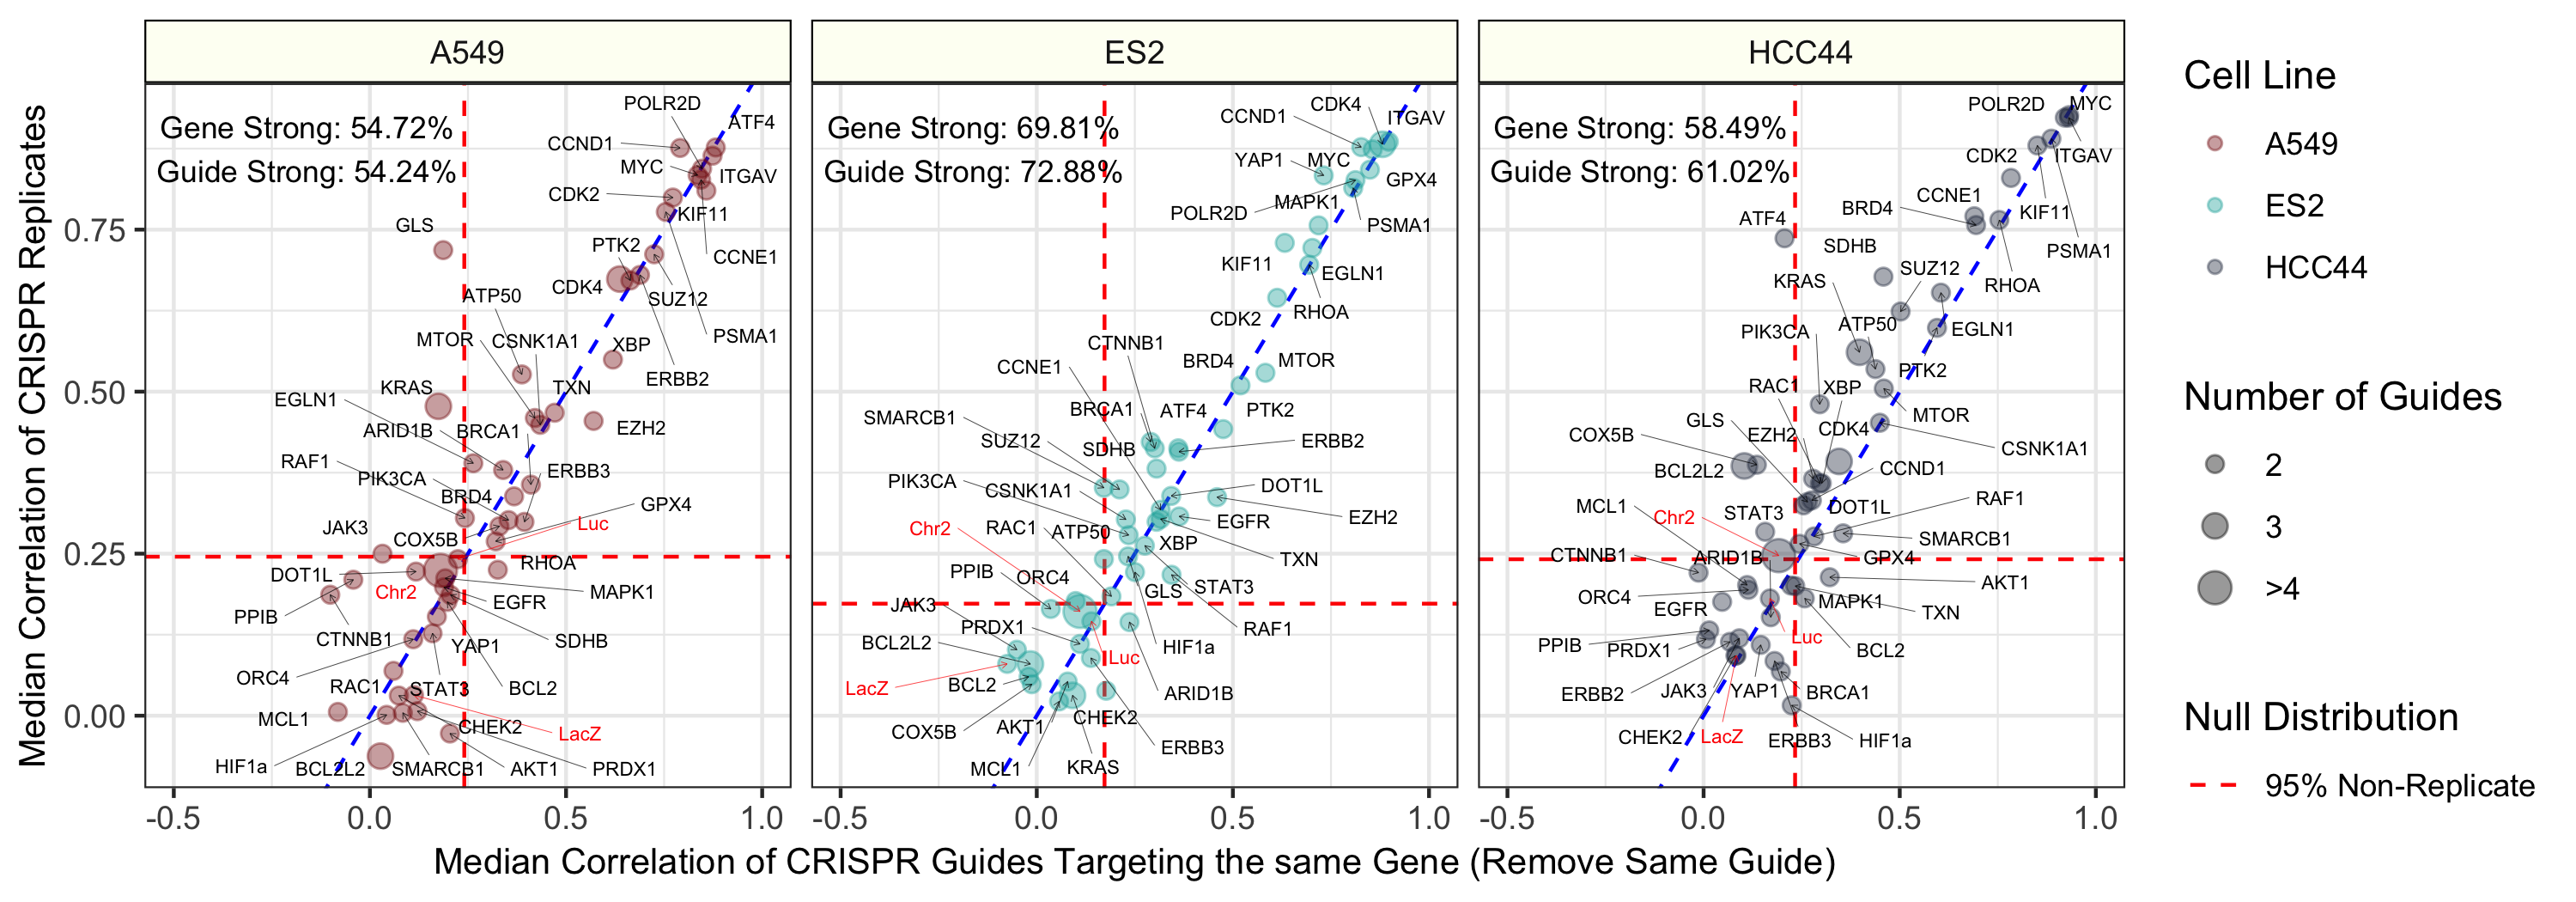

In [17]:
%%R -i summary_corr_df -i guide_non_replicate_quantile -i gene_non_replicate_quantile -i profile_strong -h 3.5 -w 10 --units in -r 300

suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))

source(file.path("..", "3.train", "scripts", "assay_themes.R"))

axis_title_size <- 10
axis_text_size <- 9
strip_text_size <- 9
ggrepel_label_size <- 1.9
title_text_size <- 10

summary_corr_df$num_guides_plot <-
    factor(summary_corr_df$num_guides_plot, levels = c("1", "2", "3", ">4"))

audit_guide_plot_df <- summary_corr_df %>% dplyr::filter(replicate_type == "Replicate")

text_color_logic <- audit_guide_plot_df$Metadata_gene_name %in% c("LacZ", "Luc", "Chr2")
control_text_color <- ifelse(text_color_logic, "red", "black")

guide_correlation_gg <-
    ggplot(audit_guide_plot_df,
           aes(x = correlation_gene,
               y = correlation_guide)) +
    geom_abline(yintercept = 0, slope = 1, linetype = "dashed", color = "blue") +
    geom_vline(data = gene_non_replicate_quantile,
               aes(xintercept = correlation_null),
               color = "red",
               linetype = "dashed") +
    geom_hline(data = guide_non_replicate_quantile,
               aes(yintercept = correlation_null, linetype = random),
               color = "red") +
    geom_point(aes(color=Metadata_cell_line,
                   size=num_guides_plot),
               alpha = 0.4) +
    geom_text(data = profile_strong,
              x = -0.16,
              y = 0.875,
              size = 3,
              aes(label = strength_text)) +
    geom_text_repel(arrow = arrow(length = unit(0.01, "npc")),
                    size = ggrepel_label_size,
                    segment.size = 0.1,
                    segment.alpha = 0.8,
                    force = 20,
                    color = control_text_color,
                    aes(x = correlation_gene,
                        y = correlation_guide,
                        label = Metadata_gene_name)) +
    xlab("Median Correlation of CRISPR Guides Targeting the same Gene (Remove Same Guide)") +
    ylab("Median Correlation of CRISPR Replicates") +
    facet_grid(~Metadata_cell_line) +
    scale_color_manual(name = "Cell Line",
                       values = cell_line_colors,
                       labels = cell_line_labels) +
    scale_size_manual(name = "Number of Guides",
                      labels=c("1" = "1",
                               "2" = "2",
                               "3" = "3",
                               ">4" = ">4"),
                      values=c("1" = 1,
                               "2" = 2,
                               "3" = 3,
                               ">4" = 4)) +
    scale_linetype_manual(name = "Null Distribution", values = "dashed") +
    xlim(c(-0.5, 1)) +
    theme_bw() +
    theme(
        axis.text = element_text(size = axis_text_size),
        axis.title = element_text(size = axis_title_size),
        strip.text = element_text(size = strip_text_size),
        strip.background = element_rect(colour = "black", fill = "#fdfff4")
    ) +
    guides(color = guide_legend(order = 1),
           size = guide_legend(order = 2),
           linetype = guide_legend(order = 3))

file_base <- file.path("figures", "guide_correlation")
for (extension in c('.png', '.pdf')) {
    ggsave(guide_correlation_gg,
           filename = paste0(file_base, extension),
           dpi = 300,
           height = 3.5,
           width = 10)
}

guide_correlation_gg

/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 3 x 2 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/median-guide-correlation-density.png
  warn('Filename: {}'.format(filename))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 3 x 2 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/median-guide-correlation-density.pdf
  warn('Filename: {}'.format(filename))


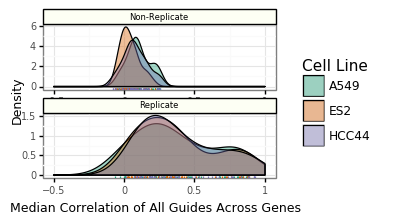

<ggplot: (321960319)>

In [18]:
gg.options.figure_size=(6.4, 4.8)

# Make sure to drop duplicates of redundant gene, perturbation, and cell line columns
# Not removing replicates will put more weight on genes with more measurements

cor_density_gg = (
    gg.ggplot(
        summary_corr_df.drop_duplicates(
            ["Metadata_cell_line", "Metadata_gene_name", "replicate_type"]
        ),
        gg.aes(x="correlation_guide")) + \
        gg.geom_density(gg.aes(fill="Metadata_cell_line"),
                        alpha=0.4) + \
        gg.geom_rug(gg.aes(color="Metadata_cell_line"),
                    show_legend={'color': False}) + \
        gg.theme_bw() + \
    gg.theme(
            subplots_adjust={"wspace": 0.2},
            axis_text=gg.element_text(size=7),
            axis_title=gg.element_text(size=9),
            strip_text=gg.element_text(size=6, color="black"),
            strip_background=gg.element_rect(colour="black", fill="#fdfff4"),
        ) + \
        gg.xlim([-0.5, 1]) + \
        gg.xlab("Median Correlation of All Guides Across Genes") + \
        gg.ylab("Density") + \
        gg.facet_wrap("~replicate_type", nrow=2, scales="free") + \
        gg.scale_fill_manual(name="Cell Line",
                             values=["#1b9e77", "#d95f02", "#7570b3"]) + \
        gg.scale_color_manual(name="Cell Line",
                              values=["#1b9e77", "#d95f02", "#7570b3"])
)

file = os.path.join("figures", "median-guide-correlation-density")
for extension in ['.png', '.pdf']:
    gg.ggsave(
        cor_density_gg,
        filename='{}{}'.format(file, extension),
        dpi=500,
        height=2,
        width=3,
        units='in'
    )

cor_density_gg